# **ML-based estimation of battery capacity and RUL prediction**

## Utilized dataset : NASA battery dataset

source: https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

### Steps to follow

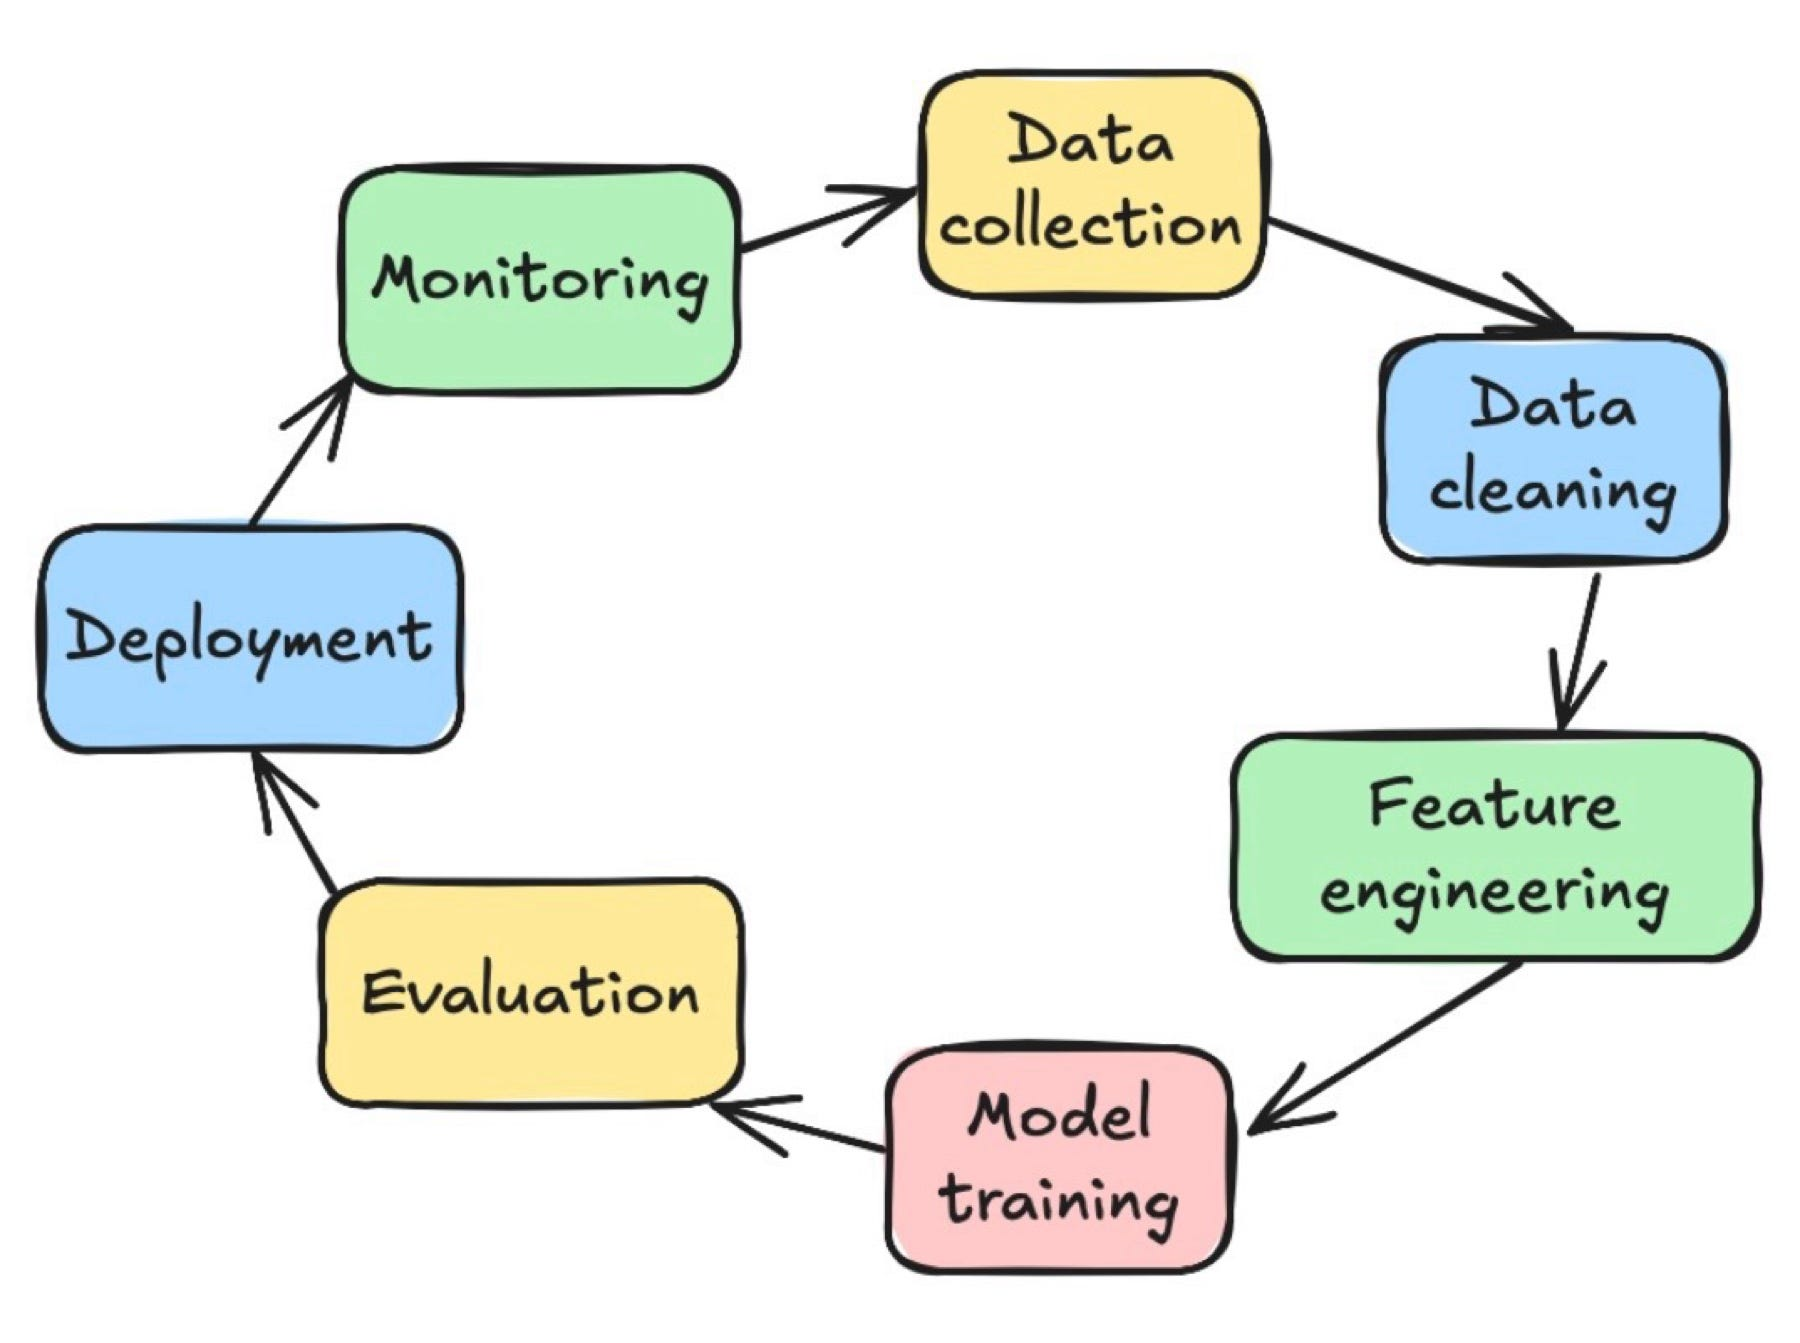

In [ ]:
# Install required packages

# !pip install seaborn
# !pip install matplotlib
# !pip install pandas
# !pip instal scikit-learn
# !pip install numpy
# !pip install xgboost

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Selected NASA 18,650 Batteries (B0005, B0006, B0007, B0018) for this task.

**Data Description:**
A set of four Li-ion batteries **(#5, #6, #7 and #18)** were run through 3 different operational profiles (charge, discharge and impedance) at room temperature. 

**battery parameters**
Nominal capicity 2Ah

**Charging Process:**
- Constant current (CC) mode at 1.5A until battery voltage reached 4.2V 
- Followed by constant voltage (CV) mode until charge current dropped to 20mA

**Discharge Process:**
- Constant current (CC) level of 2A until battery voltage fell to final discharge voltages:
	- Battery #5: 2.7V
	- Battery #6: 2.5V 
	- Battery #7: 2.2V
	- Battery #18: 2.5V

**End of Life (EOL) Criteria:**
- 30% fade in rated capacity (from 2Ah to 1.4Ah)

**Discharge Fields:**
- Voltage_measured: Battery terminal voltage (Volts)
- Current_measured: Battery output current (Amps)  
- Temperature_measured: Battery temperature (°C)
- Current_charge: Current measured at load (Amps)
- Voltage_charge: Voltage measured at load (Volts)
- Time: Time vector for the cycle (secs)
- Capacity: Battery capacity (Ah) for discharge till final discharge voltage.

### Load the datasets

In [109]:
# Load the data
# The data is in .mat format, which is a MATLAB file format.
def load_data(battery):
    mat = loadmat("battery_data/" + battery + ".mat")
    print("Total data in dataset: ", len(mat[battery][0, 0]["cycle"][0]))
    counter = 0
    dataset = []

    for i in range(len(mat[battery][0, 0]["cycle"][0])):
        row = mat[battery][0, 0]["cycle"][0, i]
        if row["type"][0] == "discharge":
            data = row["data"]
            capacity = data[0][0]["Capacity"][0][0]
            for j in range(len(data[0][0]["Voltage_measured"][0])):
                voltage_measured = data[0][0]["Voltage_measured"][0][j]
                current_measured = data[0][0]["Current_measured"][0][j]
                temperature_measured = data[0][0]["Temperature_measured"][0][j]
                current_load = data[0][0]["Current_load"][0][j]
                voltage_load = data[0][0]["Voltage_load"][0][j]
                time = data[0][0]["Time"][0][j]
                dataset.append(
                    [
                        counter + 1,
                        capacity,
                        voltage_measured,
                        current_measured,
                        temperature_measured,
                        current_load,
                        voltage_load,
                        time,
                    ]
                )
            counter = counter + 1

    return [pd.DataFrame(data=dataset,
                        columns=['cycle','capacity','voltage_measured','current_measured','temperature_measured','current_load',      'voltage_load', 'time']
                                )] 
dataset_5 = load_data("B0005") 
dataset_6 = load_data("B0006")
dataset_7 = load_data("B0007")
dataset_18 = load_data("B0018")

Total data in dataset:  616
Total data in dataset:  616
Total data in dataset:  616
Total data in dataset:  319


In [110]:
df_5 = dataset_5[0]
df_6 = dataset_6[0]
df_7 = dataset_7[0]
df_18 = dataset_18[0]

df_5["battery_id"] = 5
df_6["battery_id"] = 6
df_7["battery_id"] = 7
df_18["battery_id"] = 18

# comine all the dataframes
df = pd.concat([df_5, df_6, df_7, df_18], ignore_index=True)

df.head()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery_id
0,1,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,5
1,1,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,5
2,1,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,5
3,1,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,5
4,1,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,5


In [112]:
df.tail()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery_id
185716,132,1.341051,3.443760,-0.002426,35.383979,0.0006,0.0,2686.359,18
185717,132,1.341051,3.453271,-0.000981,35.179732,0.0006,0.0,2700.546,18
185718,132,1.341051,3.461963,0.000209,34.977000,0.0006,0.0,2714.640,18
185719,132,1.341051,3.469907,0.001516,34.785943,0.0006,0.0,2728.750,18
185720,132,1.341051,3.477277,-0.001940,34.581660,0.0006,0.0,2742.843,18


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185721 entries, 0 to 185720
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cycle                 185721 non-null  int64  
 1   capacity              185721 non-null  float64
 2   voltage_measured      185721 non-null  float64
 3   current_measured      185721 non-null  float64
 4   temperature_measured  185721 non-null  float64
 5   current_load          185721 non-null  float64
 6   voltage_load          185721 non-null  float64
 7   time                  185721 non-null  float64
 8   battery_id            185721 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 12.8 MB


### There are no NULL values

In [114]:
df.describe()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery_id
count,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000
mean,82.838758,1.574863,3.497219,-1.832569,32.378997,1.465434,2.366494,1546.379935,8.252799
std,45.692247,0.190633,0.251691,0.561405,4.027737,1.226874,0.751377,906.958628,4.743428
min,1.000000,1.153818,1.737030,-2.029098,22.350256,-2.000000,0.000000,0.000000,5.000000
25%,45.000000,1.426025,3.377653,-2.011418,29.570621,1.998200,2.410000,764.797000,5.000000
50%,81.000000,1.559634,3.500859,-2.009015,32.355737,1.998800,2.558000,1537.031000,6.000000
75%,120.000000,1.741850,3.655751,-1.989974,35.420677,1.999000,2.718000,2307.485000,7.000000
max,168.000000,2.035338,4.233325,0.014306,42.332522,2.000000,4.249000,3690.234000,18.000000


### Check for outliers

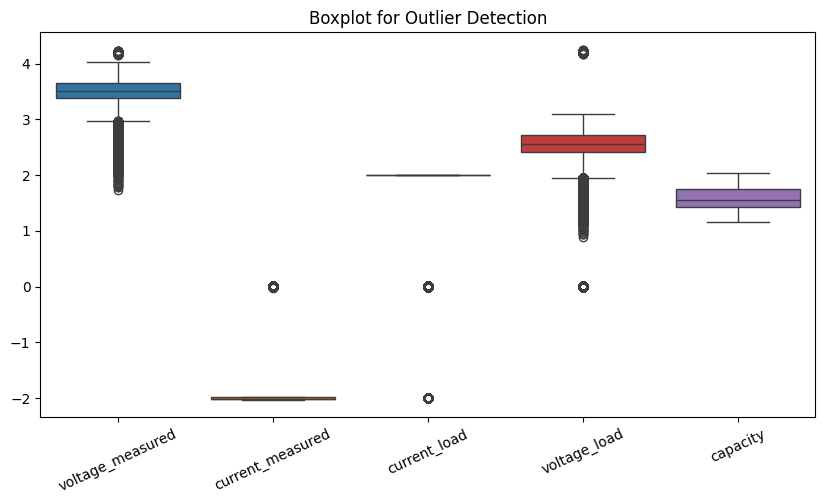

In [115]:
# Plot boxplots for all numerical features
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df[
        [
            "voltage_measured",
            "current_measured",
            "current_load",
            "voltage_load",
            "capacity",
        ]
    ]
)
plt.xticks(rotation=25)
plt.title("Boxplot for Outlier Detection")
plt.show()

## Clean outliers

In [116]:
df_clean = df.copy()
# Remove outliers

for col in ["voltage_measured",  "voltage_load"]:
    df_clean[col] = df_clean[col].clip(
        lower=df_clean[col].quantile(0.005), upper=df_clean[col].quantile(0.995)
    ) # 3% and 97% quantile replacement


for col in ["current_measured",  "current_load"]:
    df_clean[col] = df_clean[col].clip(
        lower=df_clean[col].quantile(0.01), upper=df_clean[col].quantile(0.995)
    )  # 3% and 97% quantile replacement

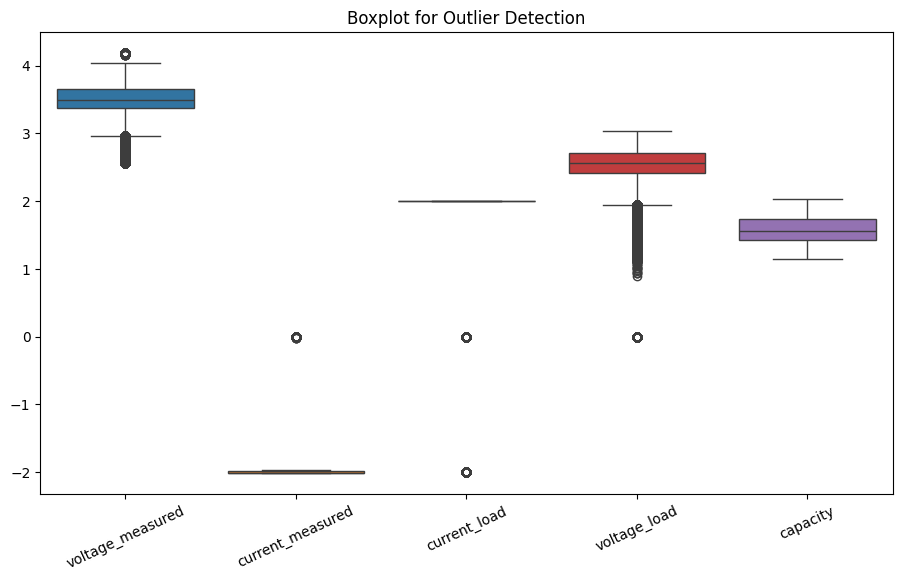

In [117]:
# Plot boxplots for all numerical features
plt.figure(figsize=(11, 6))
sns.boxplot(
    data=df_clean[
        [
            "voltage_measured",
            "current_measured",
            "current_load",
            "voltage_load",
            "capacity",
        ]
    ]
)
plt.xticks(rotation=25)
plt.title("Boxplot for Outlier Detection")
plt.show()

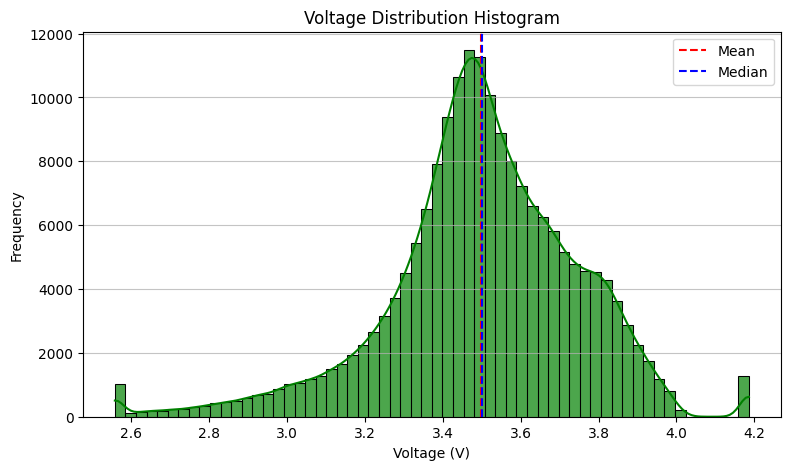

In [118]:
plt.figure(figsize=(9, 5))
sns.histplot(df_clean["voltage_measured"], kde=True, bins=60, color="green", alpha=0.7)
plt.title("Voltage Distribution Histogram")
plt.grid(axis="y", alpha=0.75)
plt.axvline(df_clean["voltage_measured"].mean(), color="red", linestyle="--", label="Mean")
plt.axvline(df_clean["voltage_measured"].median(), color="blue", linestyle="--", label="Median")
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Frequency")
plt.show()

/tmp/ipykernel_1880786/98106391.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


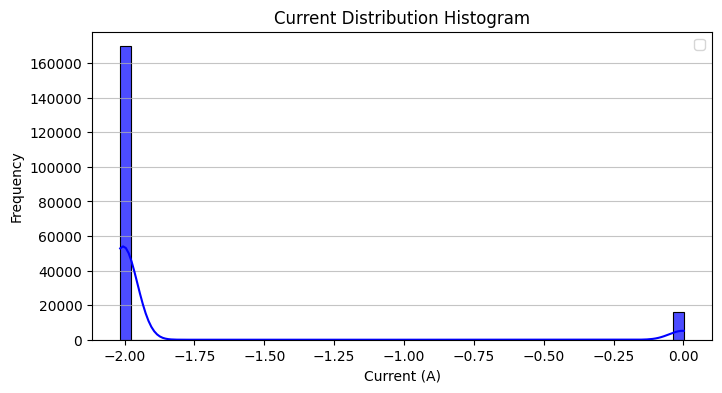

In [119]:
plt.figure(figsize=(8, 4))
sns.histplot(df_clean["current_measured"], kde=True, bins=50, color="blue", alpha=0.7)
plt.title("Current Distribution Histogram")
plt.grid(axis="y", alpha=0.75)
plt.legend()
plt.xlabel("Current (A)")
plt.ylabel("Frequency")
plt.show()

In [120]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185721 entries, 0 to 185720
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cycle                 185721 non-null  int64  
 1   capacity              185721 non-null  float64
 2   voltage_measured      185721 non-null  float64
 3   current_measured      185721 non-null  float64
 4   temperature_measured  185721 non-null  float64
 5   current_load          185721 non-null  float64
 6   voltage_load          185721 non-null  float64
 7   time                  185721 non-null  float64
 8   battery_id            185721 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 12.8 MB


In [121]:
df_clean.describe()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery_id
count,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000
mean,82.838758,1.574863,3.498113,-1.832562,32.378997,1.465434,2.362459,1546.379935,8.252799
std,45.692247,0.190633,0.247389,0.561383,4.027737,1.226874,0.744614,906.958628,4.743428
min,1.000000,1.153818,2.557492,-2.015375,22.350256,-2.000000,0.000000,0.000000,5.000000
25%,45.000000,1.426025,3.377653,-2.011418,29.570621,1.998200,2.410000,764.797000,5.000000
50%,81.000000,1.559634,3.500859,-2.009015,32.355737,1.998800,2.558000,1537.031000,6.000000
75%,120.000000,1.741850,3.655751,-1.989974,35.420677,1.999000,2.718000,2307.485000,7.000000
max,168.000000,2.035338,4.186092,0.001551,42.332522,2.000000,3.037000,3690.234000,18.000000


### **Eploratory Data analysis (EDA)**

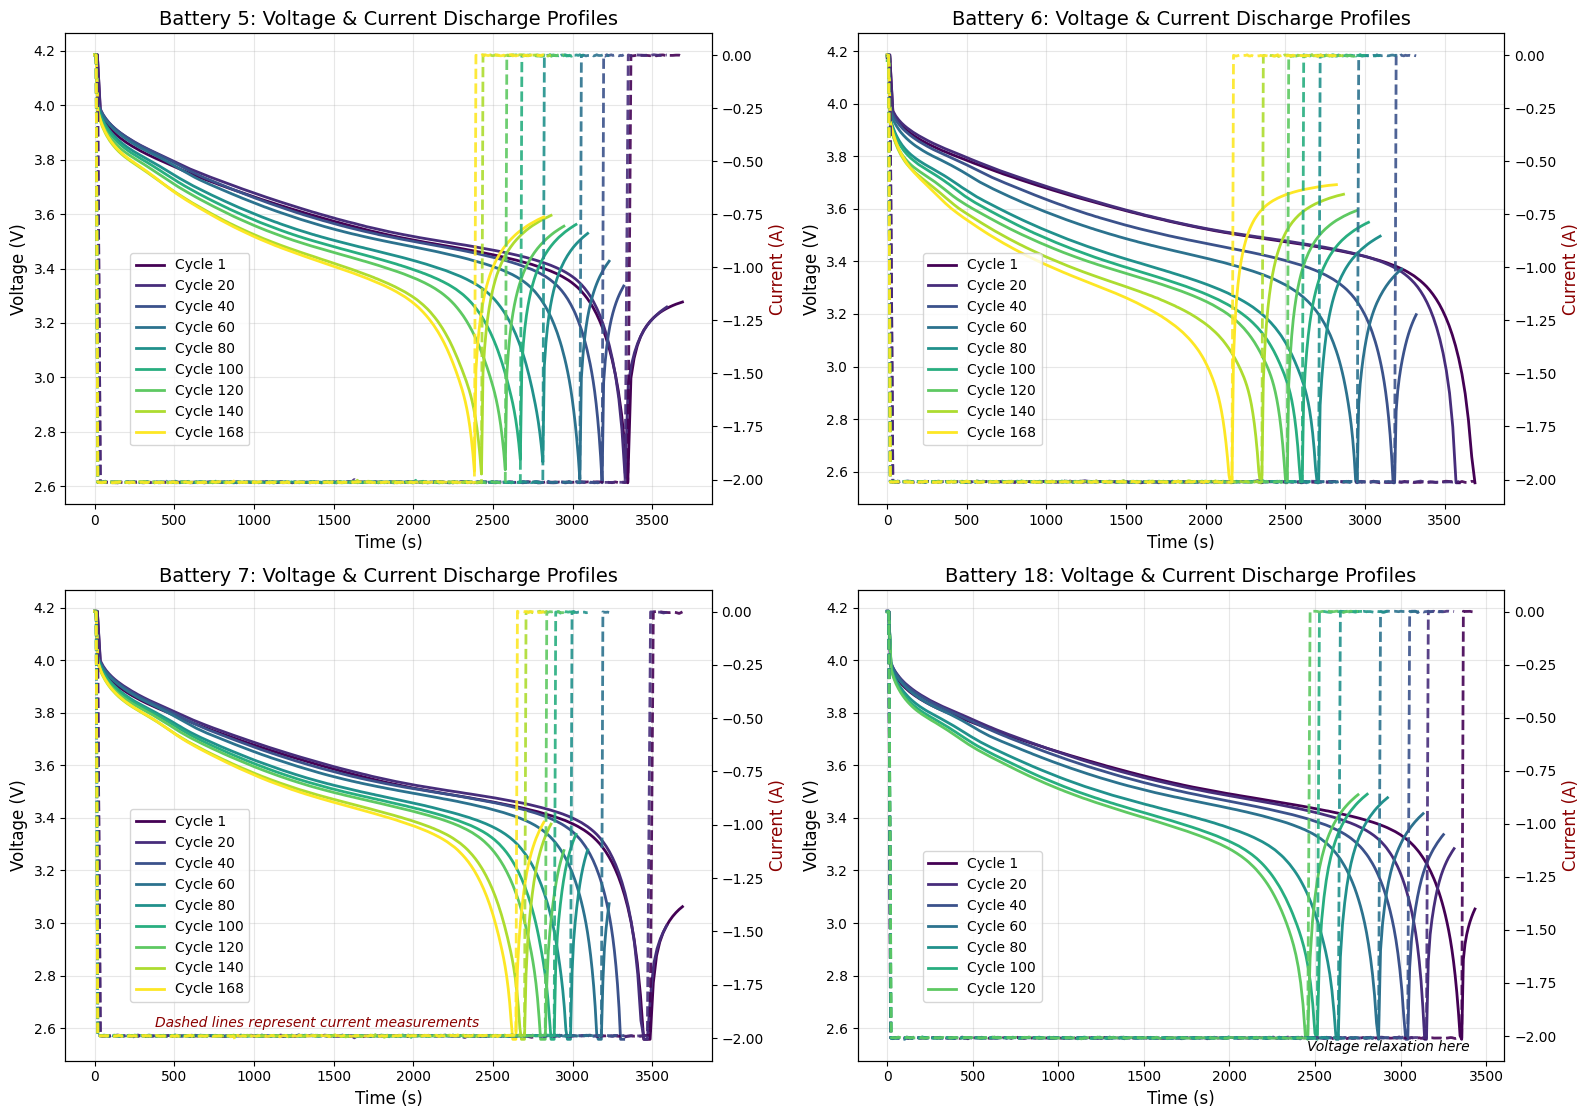

In [134]:
# Get unique battery ids and sort them (expected: [5, 6, 7, 18])
battery_ids = sorted(df_clean['battery_id'].unique())
sample_cycles = [1, 20, 40, 60, 80, 100, 120, 140, 168]
colors = plt.cm.viridis(np.linspace(0, 1, len(sample_cycles)))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, batt in zip(axes, battery_ids):
    batt_data = df_clean[df_clean['battery_id'] == batt]
    ax2 = ax.twinx()
    
    for i, cycle in enumerate(sample_cycles):
        cycle_data = batt_data[batt_data['cycle'] == cycle]
        if cycle_data.empty:
            continue
        # Plot voltage on primary y-axis
        ax.plot(cycle_data['time'], cycle_data['voltage_measured'],
                color=colors[i], label=f'Cycle {cycle}', linewidth=2)
        # Plot current on secondary y-axis with dashed line
        ax2.plot(cycle_data['time'], cycle_data['current_measured'],
                 color=colors[i], linestyle='--', alpha=0.9, linewidth=2)
    
    ax.set_title(f"Battery {batt}: Voltage & Current Discharge Profiles", fontsize=14)
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Voltage (V)", fontsize=12, color='black')
    ax2.set_ylabel("Current (A)", fontsize=12, color='darkred')
    ax.grid(True, alpha=0.3)
    ax.legend(loc="lower left", bbox_to_anchor=(0.09, 0.11))

# Add annotations to the entire figure
plt.figtext(0.10, 0.14, "Dashed lines represent current measurements", fontsize=10, style='italic', color='darkred')
plt.figtext(0.82, 0.12, "Voltage relaxation here", fontsize=10, style="italic", color="black")
plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()


### More research is needed to understand the effect of voltage relaxation to the RUL prediction

### End of Discharge voltage was 2.7 V for B0005 and 2.5 V for others

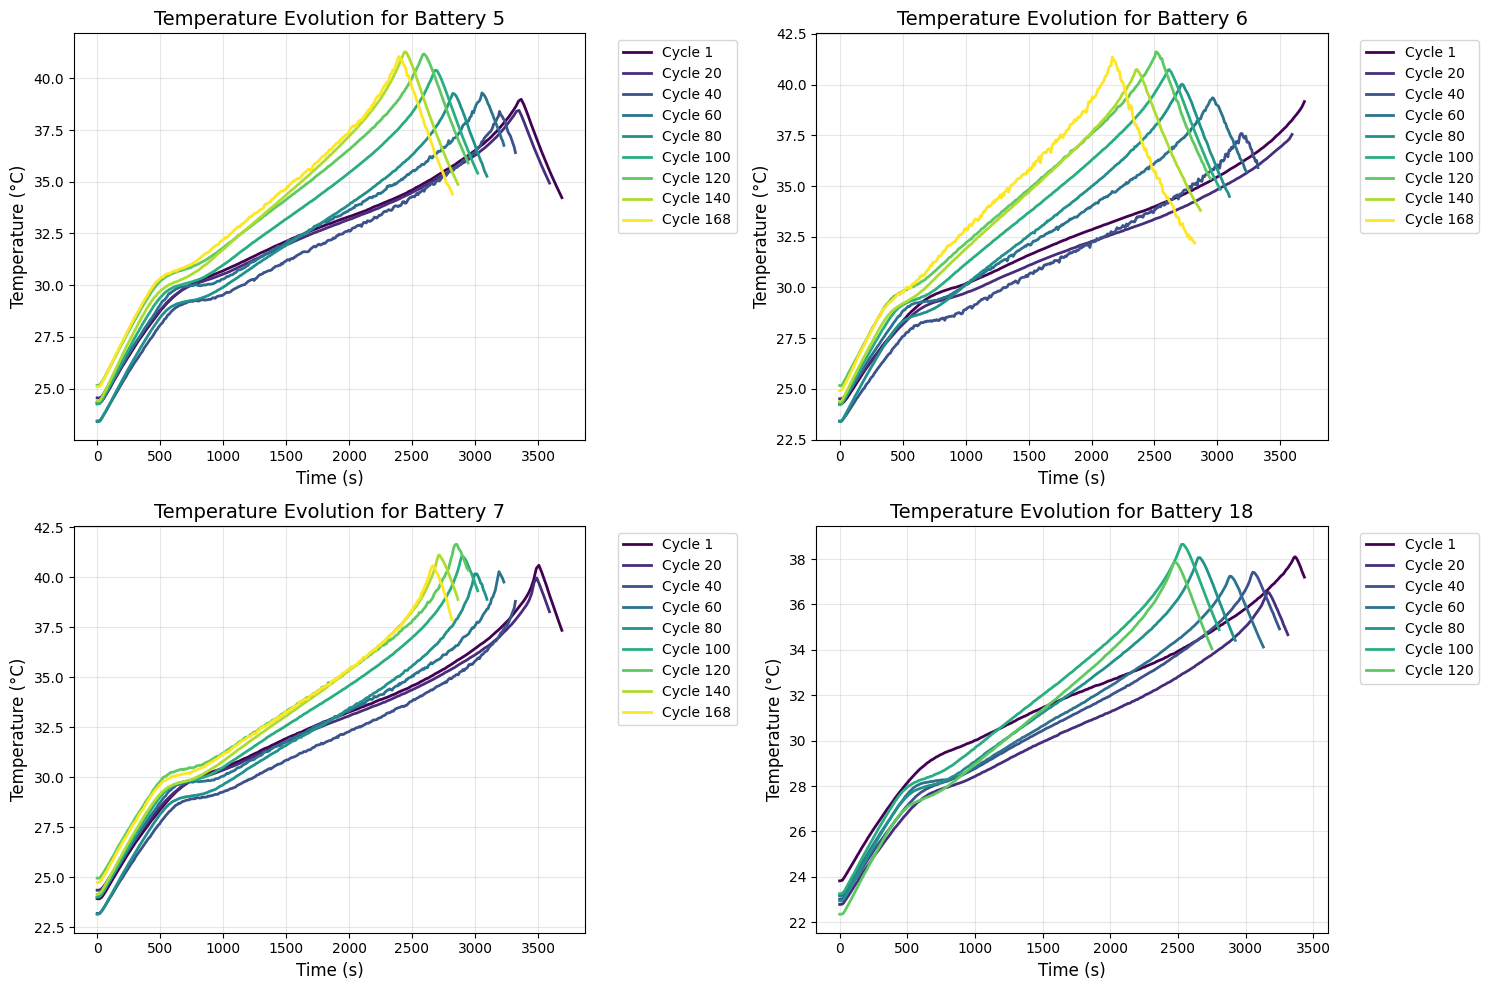

In [146]:
unique_batteries = sorted(df_clean["battery_id"].unique())
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for ax, batt in zip(axes, unique_batteries):
    batt_data = df_clean[df_clean['battery_id'] == batt]
    colors = plt.cm.viridis(np.linspace(0, 1, len(sample_cycles)))
    
    for i, cycle_num in enumerate(sample_cycles):
        cycle_data = batt_data[batt_data['cycle'] == cycle_num]
        if cycle_data.empty:
            continue
        ax.plot(cycle_data['time'], cycle_data['temperature_measured'],
                color=colors[i], label=f'Cycle {cycle_num}', linewidth=2)
    
    ax.set_title(f"Temperature Evolution for Battery {batt}", fontsize=14)
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Temperature (°C)", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Battery temperature increases with discharge time 

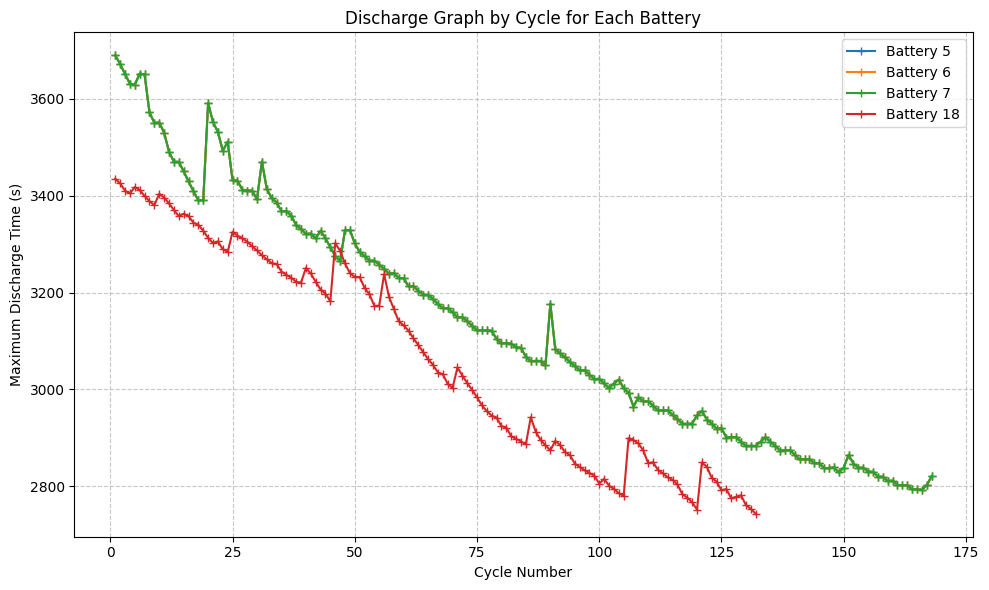

[5, 6, 7, 18]


In [147]:
# Group by battery id and plot each battery's discharge graph on the same figure
unique_batteries = sorted(df_clean["battery_id"].unique())

plt.figure(figsize=(10, 6))
for batt in unique_batteries:
    batt_df = df_clean[df_clean["battery_id"] == batt]
    discharge_time = batt_df.groupby("cycle")["time"].max()
    plt.plot(discharge_time.index, discharge_time.values, marker='+', linestyle='-', label=f'Battery {batt}')

plt.title("Discharge Graph by Cycle for Each Battery")
plt.xlabel("Cycle Number")
plt.ylabel("Maximum Discharge Time (s)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()
print(unique_batteries)

### Discharge time decreases with number of discharge cycles. Similar to battery capacity.

## Feature Engineering.

List of features to engineer

Feature Engineering (temperature fluctuations, internal resistance, cycle count, depth of discharge (DoD), and charge/discharge rates) Methods to extract detailed information, such as voltage relaxation characteristics and charge capacity fading patterns

In [148]:
df_clean.head()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery_id
0,1,1.856487,4.186092,-0.004902,24.330034,-0.0006,0.000,0.000,5
1,1,1.856487,4.186092,-0.001478,24.325993,-0.0006,3.037,16.781,5
2,1,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.037,35.703,5
3,1,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,5
4,1,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,5


### Add SoC to the dataset:  **Coulomb Counting method**

### Formula: SoC(t) = SoC(t-1) + (I(t) * dt) / Capacity

### SoC relationship per cycle. Not time. Add 

In [150]:
initial_soc = 1.0  # starting with 100% SoC

df_clean.sort_values(["battery_id", "cycle", "time"], inplace=True)

# Compute time difference per cycle in seconds and convert to hours
df_clean["dt_seconds"] = df_clean.groupby(["battery_id", "cycle"])["time"].diff().fillna(0)
df_clean["dt_hours"] = df_clean["dt_seconds"] / 3600.0

# Compute charge removed (dQ) in Ah for each row
df_clean["dQ_Ah"] = df_clean["current_measured"] * df_clean["dt_hours"]

# Compute the cumulative relative charge change for each battery id and cycle
cumulative_relative_charge_change = (
    df_clean.groupby(["battery_id", "cycle"])
    .apply(lambda g: (g["dQ_Ah"] / g["capacity"]).cumsum())
    .reset_index(level=[0, 1], drop=True)
)

# Compute SoC by adding the cumulative change to the initial SoC, then clip between 0 and 1
df_clean["SoC"] = (initial_soc + cumulative_relative_charge_change).clip(0, 1)

df_clean.drop(columns=["dt_seconds", "dt_hours", "dQ_Ah"], inplace=True)
df_clean.head()

/tmp/ipykernel_1880786/518779305.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["dQ_Ah"] / g["capacity"]).cumsum())


,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery_id,SoC
0,1,1.856487,4.186092,-0.004902,24.330034,-0.0006,0.000,0.000,5,1.000000
1,1,1.856487,4.186092,-0.001478,24.325993,-0.0006,3.037,16.781,5,0.999996
2,1,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.037,35.703,5,0.994298
3,1,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,5,0.988851
4,1,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,5,0.983392


In [151]:
df_clean.tail()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery_id,SoC
185716,132,1.341051,3.443760,-0.002426,35.383979,0.0006,0.0,2686.359,18,0.0
185717,132,1.341051,3.453271,-0.000981,35.179732,0.0006,0.0,2700.546,18,0.0
185718,132,1.341051,3.461963,0.000209,34.977000,0.0006,0.0,2714.640,18,0.0
185719,132,1.341051,3.469907,0.001516,34.785943,0.0006,0.0,2728.750,18,0.0
185720,132,1.341051,3.477277,-0.001940,34.581660,0.0006,0.0,2742.843,18,0.0


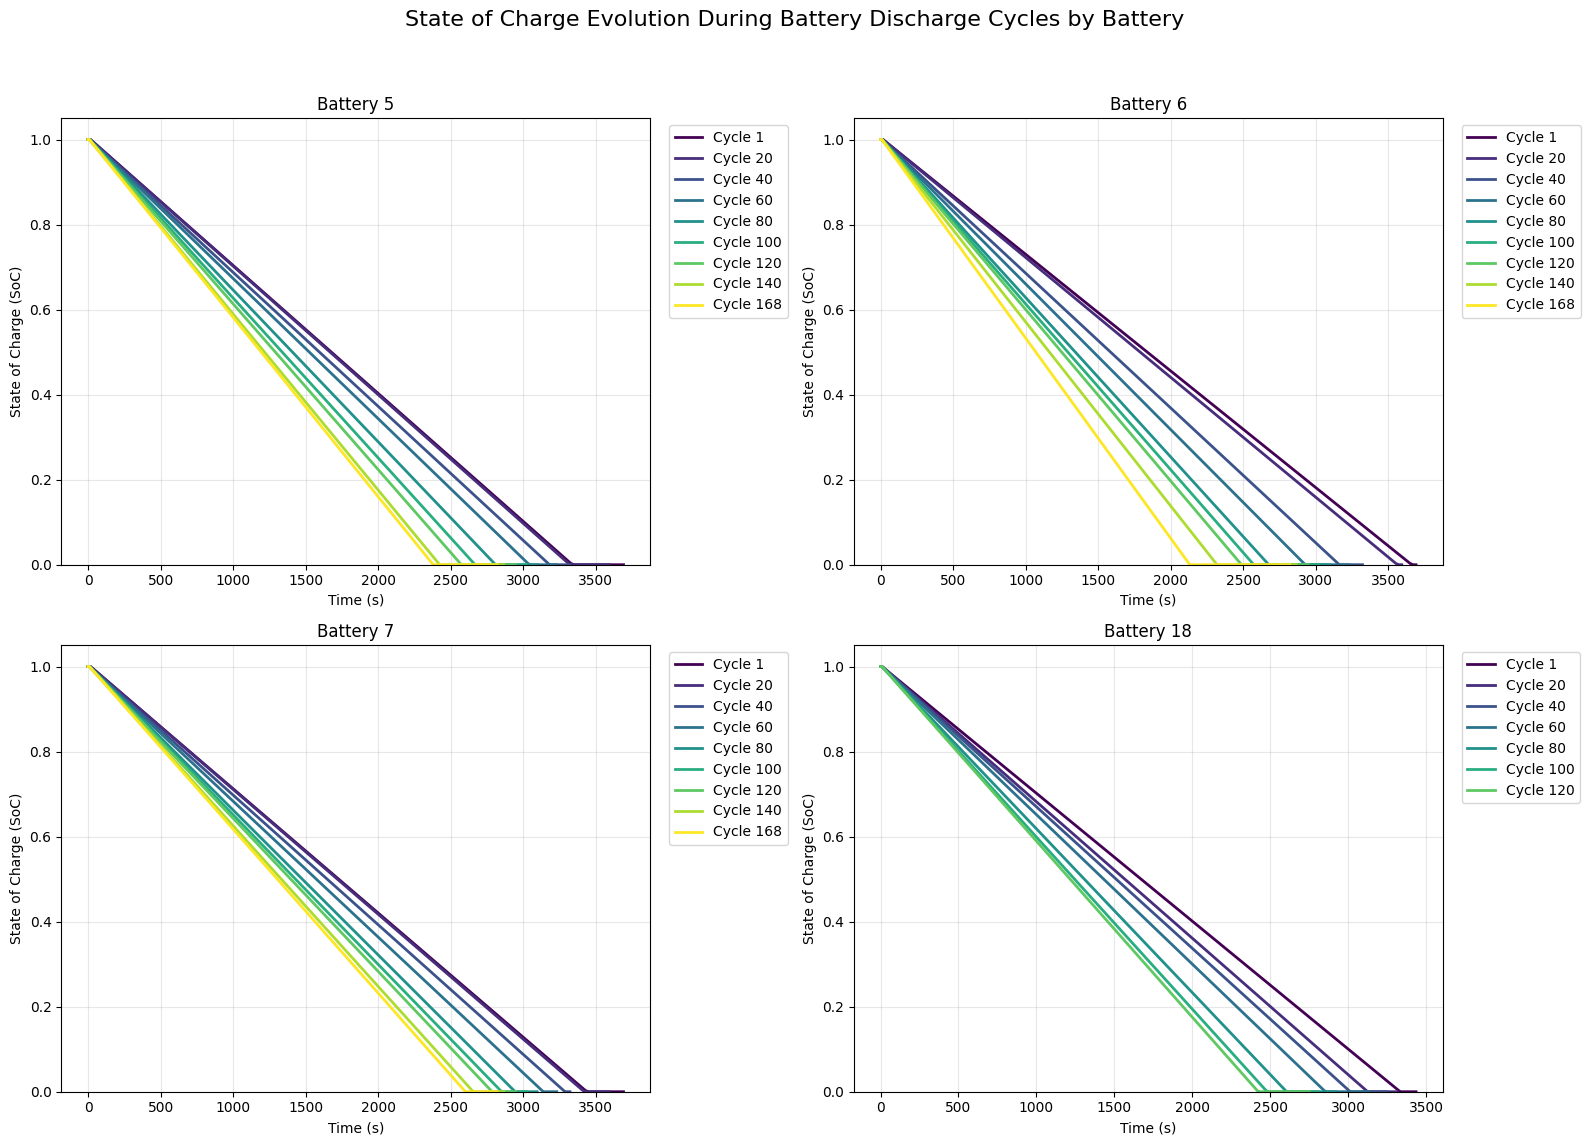

In [152]:
# Use the same sample cycles and color palette
sample_cycles = [1, 20, 40, 60, 80, 100, 120, 140, 168]
colors = plt.cm.viridis(np.linspace(0, 1, len(sample_cycles)))

# Get the unique battery ids from the dataset
unique_batteries = sorted(df_clean["battery_id"].unique())

# Create subplots (2x2 for 4 batteries)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, batt in zip(axes, unique_batteries):
    batt_data = df_clean[df_clean["battery_id"] == batt]
    for i, cycle in enumerate(sample_cycles):
        cycle_data = batt_data[batt_data["cycle"] == cycle]
        if cycle_data.empty:
            continue
        ax.plot(
            cycle_data["time"],
            cycle_data["SoC"],
            color=colors[i],
            label=f"Cycle {cycle}",
            linewidth=2,
        )
    ax.set_title(f"Battery {batt}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("State of Charge (SoC)")
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.suptitle(
    "State of Charge Evolution During Battery Discharge Cycles by Battery",
    fontsize=16,
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Full discharge cycles which are not realistic in the real world

### # DOD (Depth of Discharge)

In [153]:
# DOD (Depth of Discharge)
df_clean["DOD"] = 1 - df_clean["SoC"]
df_clean.head()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery_id,SoC,DOD
0,1,1.856487,4.186092,-0.004902,24.330034,-0.0006,0.000,0.000,5,1.000000,0.000000
1,1,1.856487,4.186092,-0.001478,24.325993,-0.0006,3.037,16.781,5,0.999996,0.000004
2,1,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.037,35.703,5,0.994298,0.005702
3,1,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,5,0.988851,0.011149
4,1,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,5,0.983392,0.016608


### important features

In [227]:
init_capacity = 2.0

# Group by battery_id and cycle, then aggregate required statistics.
grouped = df_clean.groupby(["battery_id", "cycle"]).agg(
    capacity=("capacity", "first"),
    time_min=("time", "min"),
    time_max=("time", "max"),
    soc_first=("SoC", "first"),
    soc_last=("SoC", "last")
).reset_index()

# Compute discharge time (s), delta SoC per hour, and State of Health (SOH)
grouped["discharge_time"] = grouped["time_max"] - grouped["time_min"]
grouped["delta_SOC"] = -(grouped["soc_first"] - grouped["soc_last"]) / (grouped["discharge_time"] / 3600)
grouped["SOH"] = grouped["capacity"] / init_capacity

# Organize final feature DataFrame
features = grouped[["battery_id", "cycle", "capacity", "SOH", "delta_SOC", "discharge_time"]]

features.head()

,battery_id,cycle,capacity,SOH,delta_SOC,discharge_time
0,5,1,1.856487,0.928244,-0.975548,3690.234
1,5,2,1.846327,0.923164,-0.980300,3672.344
2,5,3,1.835349,0.917675,-0.985858,3651.641
3,5,4,1.835263,0.917631,-0.991309,3631.563
4,5,5,1.834646,0.917323,-0.991962,3629.172


In [228]:
features.iloc[123:126]  # verify eol cycle

,battery_id,cycle,capacity,SOH,delta_SOC,discharge_time
123,5,124,1.401204,0.700602,-1.233563,2918.375
124,5,125,1.396701,0.698350,-1.232956,2919.812
125,5,126,1.391285,0.695642,-1.241199,2900.422


## SOH and Delta SOC vs Cycle Number

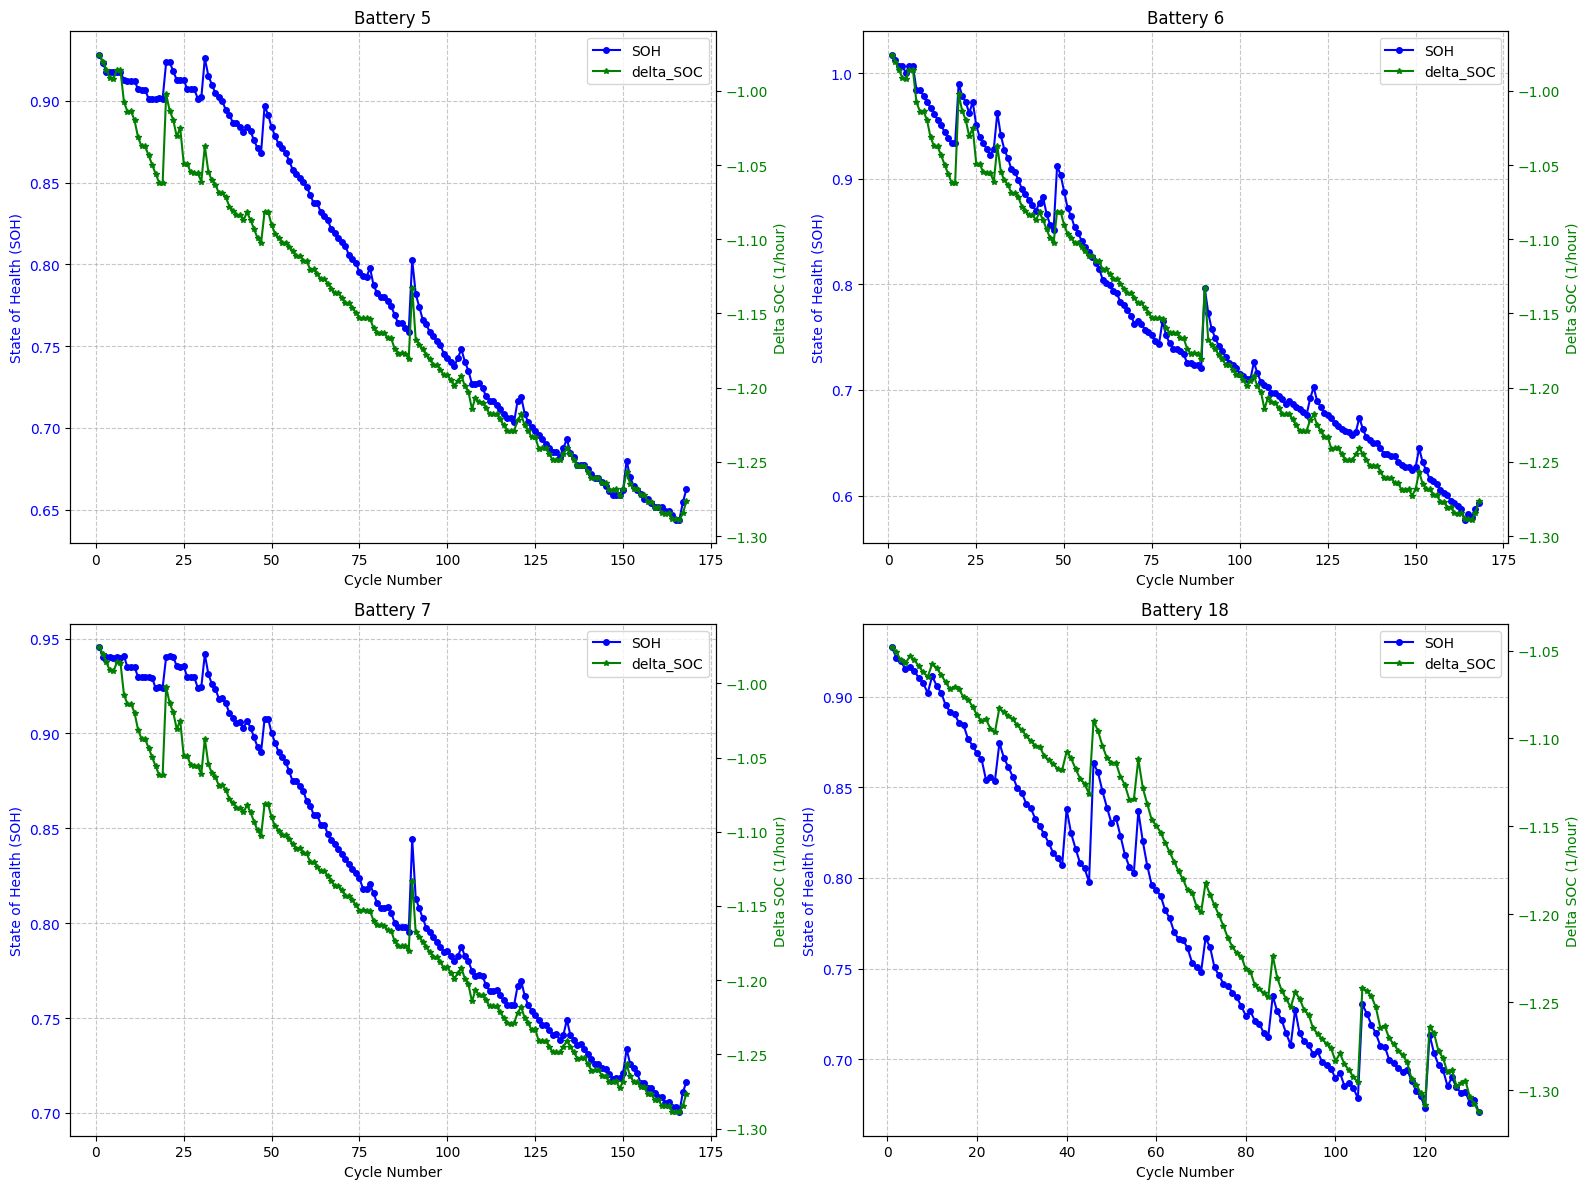

In [229]:
# Create figure with two y-axes
# Separate plots for each battery using subplots with two y-axes (SOH and delta_SOC)
unique_batteries = sorted(features["battery_id"].unique())
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, batt in enumerate(unique_batteries):
    data = features[features["battery_id"] == batt]
    ax = axes[i]
    ax_twin = ax.twinx()
    
    # Plot SOH on primary y-axis
    ax.plot(data["cycle"], data["SOH"], marker="o", color="blue", linestyle="-", label="SOH", markersize=4)
    ax.set_ylabel("State of Health (SOH)", color="blue")
    ax.tick_params(axis="y", labelcolor="blue")
    
    # Plot delta_SOC on secondary y-axis
    ax_twin.plot(data["cycle"], data["delta_SOC"], marker="*", color="green", linestyle="-", label="delta_SOC", markersize=4)
    ax_twin.set_ylabel("Delta SOC (1/hour)", color="green")
    ax_twin.tick_params(axis="y", labelcolor="green")
    
    # Set common x-axis label and title for each subplot
    ax.set_xlabel("Cycle Number")
    ax.set_title(f"Battery {batt}")
    
    # Combine legends from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_twin.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
    
    ax.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## Voltage, current and temperature features

In [230]:
# Group the cleaned data by battery id and cycle to compute fluctuation metrics
cycle_groups = df_clean.groupby(["battery_id", "cycle"])

# Compute aggregated statistics for voltage, current, and temperature
df_stats = cycle_groups.agg(
    voltage_mean=("voltage_measured", "mean"),
    voltage_min=("voltage_measured", "min"),
    voltage_max=("voltage_measured", "max"),
    current_mean=("current_measured", "mean"),
    current_min=("current_measured", "min"),
    current_max=("current_measured", "max"),
    temp_mean=("temperature_measured", "mean"),
    temp_min=("temperature_measured", "min"),
    temp_max=("temperature_measured", "max"),
).reset_index()

# Merge these new statistics with the existing features DataFrame
features = features.merge(
    df_stats[
        [
            "battery_id",
            "cycle",
            "voltage_mean",
            "voltage_min",
            "voltage_max",
            "current_mean",
            "current_min",
            "current_max",
            "temp_mean",
            "temp_min",
            "temp_max",
        ]
    ],
    on=["battery_id", "cycle"],
    how="left",
)

features.head()

,battery_id,cycle,capacity,SOH,delta_SOC,discharge_time,voltage_mean,voltage_min,voltage_max,current_mean,current_min,current_max,temp_mean,temp_min,temp_max
0,5,1,1.856487,0.928244,-0.975548,3690.234,3.529778,2.612467,4.186092,-1.818672,-2.015375,0.000729,32.572328,24.325993,38.982181
1,5,2,1.846327,0.923164,-0.980300,3672.344,3.537287,2.587209,4.186092,-1.817552,-2.015375,0.001551,32.725235,24.685948,39.033398
2,5,3,1.835349,0.917675,-0.985858,3651.641,3.543720,2.651917,4.186092,-1.816470,-2.015375,0.001484,32.642862,24.734266,38.818797
3,5,4,1.835263,0.917631,-0.991309,3631.563,3.543645,2.592948,4.186092,-1.825584,-2.015375,0.001547,32.514876,24.652244,38.762305
4,5,5,1.834646,0.917323,-0.991962,3629.172,3.542377,2.557492,4.186092,-1.826085,-2.015375,0.001551,32.382349,24.518700,38.665393


### Computation of internal resistance feature. Used volatge drop method

In [231]:
def calculate_internal_resistance_by_battery(df):
    results = []
    # Iterate over each unique battery
    for battery in df['battery_id'].unique():
        df_batt = df[df['battery_id'] == battery]
        # Iterate over each unique cycle within the battery
        for cycle in sorted(df_batt["cycle"].unique()):
            cycle_data = df_batt[df_batt["cycle"] == cycle].reset_index(drop=True)
            cycle_data = cycle_data.sort_values("time")
            
            # Find the start of significant discharge (first point where current < -1.95A)
            discharge_idx = cycle_data[cycle_data["current_measured"] < -1.85].index
            
            if len(discharge_idx) == 0:
                R = np.nan
            else:
                start_idx = discharge_idx[0]
                # Get the open circuit voltage (last measurement before discharge)
                if start_idx > 0:
                    V_open = cycle_data.iloc[start_idx - 1]["voltage_measured"]
                else:
                    V_open = cycle_data.iloc[0]["voltage_measured"]
                
                t_start = cycle_data.iloc[start_idx]["time"]
                t_35s = t_start + 35  # 35 seconds after the start of significant discharge
                
                # Find the nearest time point to t_35s
                closest_idx = cycle_data.iloc[(cycle_data["time"] - t_35s).abs().argsort()[0]].name
                V_35s = cycle_data.loc[closest_idx, "voltage_measured"]
                
                I_discharge = cycle_data.loc[closest_idx, "current_measured"]
                R = abs((V_open - V_35s) / I_discharge)
            
            results.append({"battery_id": battery, "cycle": cycle, "internal_resistance": R})
    
    return pd.DataFrame(results)

r_df = calculate_internal_resistance_by_battery(df_clean)

# Merge 
features = features.merge(r_df, on=["battery_id", "cycle"], how="left")
features.head()


,battery_id,cycle,capacity,SOH,delta_SOC,discharge_time,voltage_mean,voltage_min,voltage_max,current_mean,current_min,current_max,temp_mean,temp_min,temp_max,internal_resistance
0,5,1,1.856487,0.928244,-0.975548,3690.234,3.529778,2.612467,4.186092,-1.818672,-2.015375,0.000729,32.572328,24.325993,38.982181,0.125172
1,5,2,1.846327,0.923164,-0.980300,3672.344,3.537287,2.587209,4.186092,-1.817552,-2.015375,0.001551,32.725235,24.685948,39.033398,0.122237
2,5,3,1.835349,0.917675,-0.985858,3651.641,3.543720,2.651917,4.186092,-1.816470,-2.015375,0.001484,32.642862,24.734266,38.818797,0.121487
3,5,4,1.835263,0.917631,-0.991309,3631.563,3.543645,2.592948,4.186092,-1.825584,-2.015375,0.001547,32.514876,24.652244,38.762305,0.120511
4,5,5,1.834646,0.917323,-0.991962,3629.172,3.542377,2.557492,4.186092,-1.826085,-2.015375,0.001551,32.382349,24.518700,38.665393,0.120239


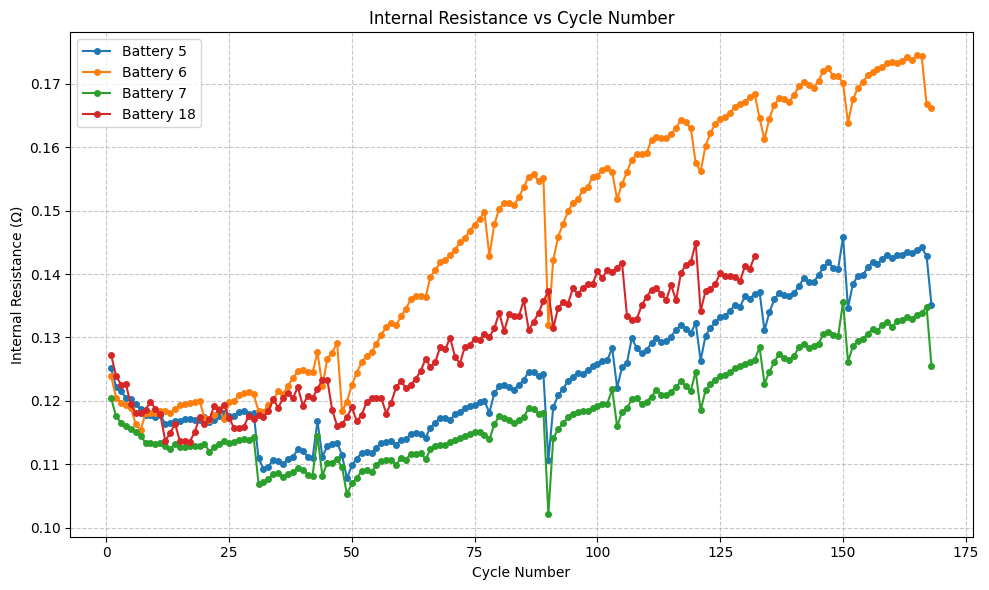

In [232]:
unique_batteries = sorted(features["battery_id"].unique())

plt.figure(figsize=(10, 6))
for batt in unique_batteries:
    subset = features[features["battery_id"] == batt]
    plt.plot(
        subset["cycle"],
        subset["internal_resistance"],
        marker="o",
        linestyle="-",
        markersize=4,
        label=f"Battery {batt}",
    )

plt.title("Internal Resistance vs Cycle Number")
plt.xlabel("Cycle Number")
plt.ylabel("Internal Resistance (Ω)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

# Add RUL feature which will be the target

### Remaining useful life (RUL) is the amount of time/cycles a battery is likely to operate before it requires repair or replacement. 

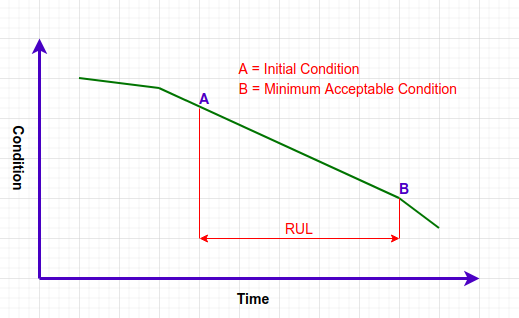

In [233]:
# Set nominal and end-of-life capacity values (Ah)
init_capacity = 2.0
eol_capacity = 1.401
print("Nominal capacity:", init_capacity)
print("End of life capacity:", eol_capacity)

# Compute the end-of-life cycle per battery and store in a dictionary
eol_dict = {}
for batt in features["battery_id"].unique():
    batt_feats = features[features["battery_id"] == batt]
    eol_cycle = batt_feats[batt_feats["capacity"] <= eol_capacity]["cycle"].min()
    eol_dict[batt] = eol_cycle
    print(f"Battery {batt}: End of Life Cycle: {eol_cycle}")

# Update the "RUL" feature for each battery
features["RUL"] = features.apply(lambda row: eol_dict[row["battery_id"]] - row["cycle"], axis=1)
features.tail(10)

Nominal capacity: 2.0
End of life capacity: 1.401
Battery 5: End of Life Cycle: 125
Battery 6: End of Life Cycle: 109
Battery 7: End of Life Cycle: 166
Battery 18: End of Life Cycle: 97


,battery_id,cycle,capacity,SOH,delta_SOC,discharge_time,voltage_mean,voltage_min,voltage_max,current_mean,current_min,current_max,temp_mean,temp_min,temp_max,internal_resistance,RUL
626,18,123,1.393491,0.696745,-1.277785,2817.375,3.460739,2.557492,4.186092,-1.797026,-2.012421,0.001551,31.111641,23.111863,38.083072,0.137640,-26.0
627,18,124,1.388249,0.694125,-1.281488,2809.234,3.462725,2.557492,4.186092,-1.786168,-2.013158,0.001551,31.037910,23.044171,37.882796,0.138442,-27.0
628,18,125,1.370188,0.685094,-1.289774,2791.187,3.456352,2.557492,4.183907,-1.784188,-2.012317,0.001551,30.967951,22.834265,37.960271,0.140204,-28.0
629,18,126,1.379695,0.689848,-1.288468,2794.016,3.459200,2.557492,4.185339,-1.784545,-2.015225,0.001551,30.939962,22.835893,37.880513,0.139647,-29.0
630,18,127,1.368659,0.684329,-1.297429,2774.719,3.453925,2.557492,4.185280,-1.792277,-2.014214,0.001551,31.295019,23.179921,38.434163,0.139697,-30.0
631,18,128,1.362737,0.681369,-1.295969,2777.844,3.456271,2.557492,4.186092,-1.782781,-2.012842,0.001551,31.818465,23.715085,38.847490,0.139502,-31.0
632,18,129,1.363405,0.681703,-1.294440,2781.125,3.462313,2.557492,4.185356,-1.772554,-2.014393,0.001551,32.000672,24.038522,38.802834,0.138873,-32.0
633,18,130,1.351865,0.675932,-1.303920,2760.906,3.453005,2.557492,4.181407,-1.769891,-2.012836,0.001551,31.739922,23.562888,38.726991,0.141217,-33.0
634,18,131,1.354797,0.677398,-1.307546,2753.250,3.449282,2.557492,4.185252,-1.788504,-2.011864,0.001551,31.526136,23.401477,38.671920,0.140820,-34.0
635,18,132,1.341051,0.670526,-1.312507,2742.843,3.448888,2.557492,4.185763,-1.777760,-2.012869,0.001551,31.276245,23.123583,38.371814,0.142825,-35.0


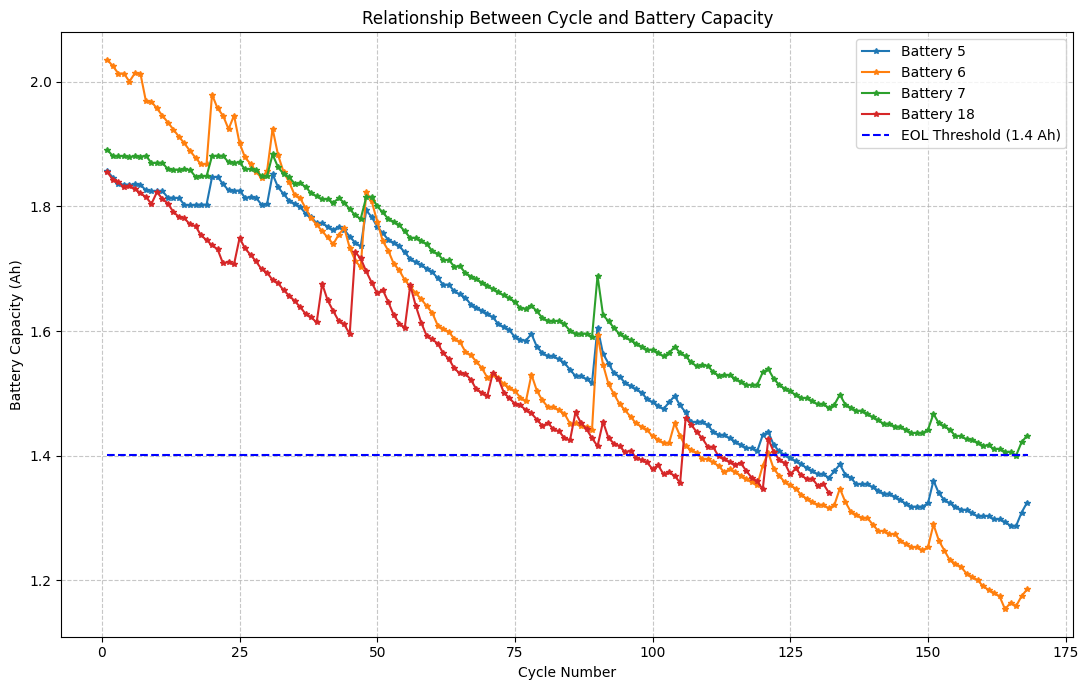

In [234]:
plt.figure(figsize=(11, 7))

# Plot capacity curve for each battery
for batt in sorted(features["battery_id"].unique()):
    sub = features[features["battery_id"] == batt]
    plt.plot(sub["cycle"], sub["capacity"], marker="*", markersize=4, label=f"Battery {batt}")

# Plot threshold line for EOL 
eol_threshold_line = np.full(features["cycle"].shape, eol_capacity)
plt.plot(features["cycle"], eol_threshold_line, "--", color="blue", label="EOL Threshold (1.4 Ah)")
# # Place the text at the mid-cycle point slightly above the line
# mid_cycle = features["cycle"].max() * 0.5
# plt.text(mid_cycle, eol_capacity - 0.05, "EOL Threshold", color="blue", fontsize=10)

plt.title("Relationship Between Cycle and Battery Capacity")
plt.xlabel("Cycle Number")
plt.ylabel("Battery Capacity (Ah)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

In [235]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   battery_id           636 non-null    int64  
 1   cycle                636 non-null    int64  
 2   capacity             636 non-null    float64
 3   SOH                  636 non-null    float64
 4   delta_SOC            636 non-null    float64
 5   discharge_time       636 non-null    float64
 6   voltage_mean         636 non-null    float64
 7   voltage_min          636 non-null    float64
 8   voltage_max          636 non-null    float64
 9   current_mean         636 non-null    float64
 10  current_min          636 non-null    float64
 11  current_max          636 non-null    float64
 12  temp_mean            636 non-null    float64
 13  temp_min             636 non-null    float64
 14  temp_max             636 non-null    float64
 15  internal_resistance  636 non-null    flo

# Input Feature Selection

### Determin feature importance using correletaion

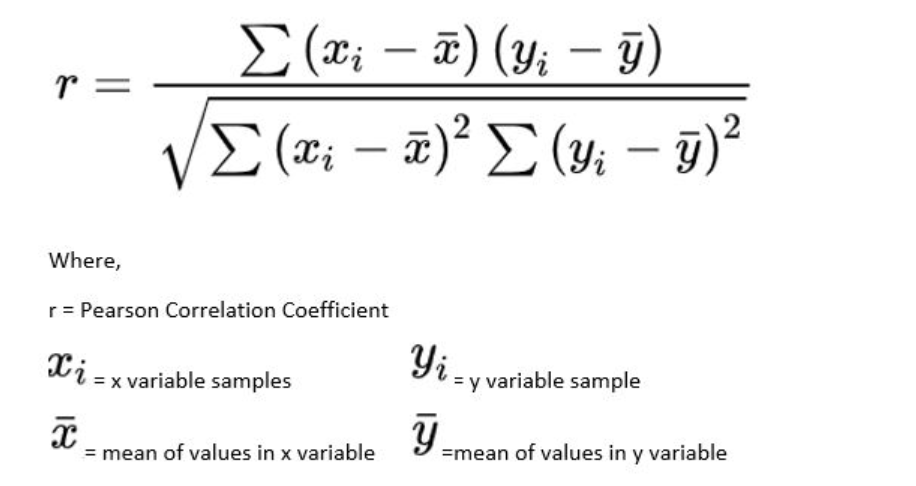

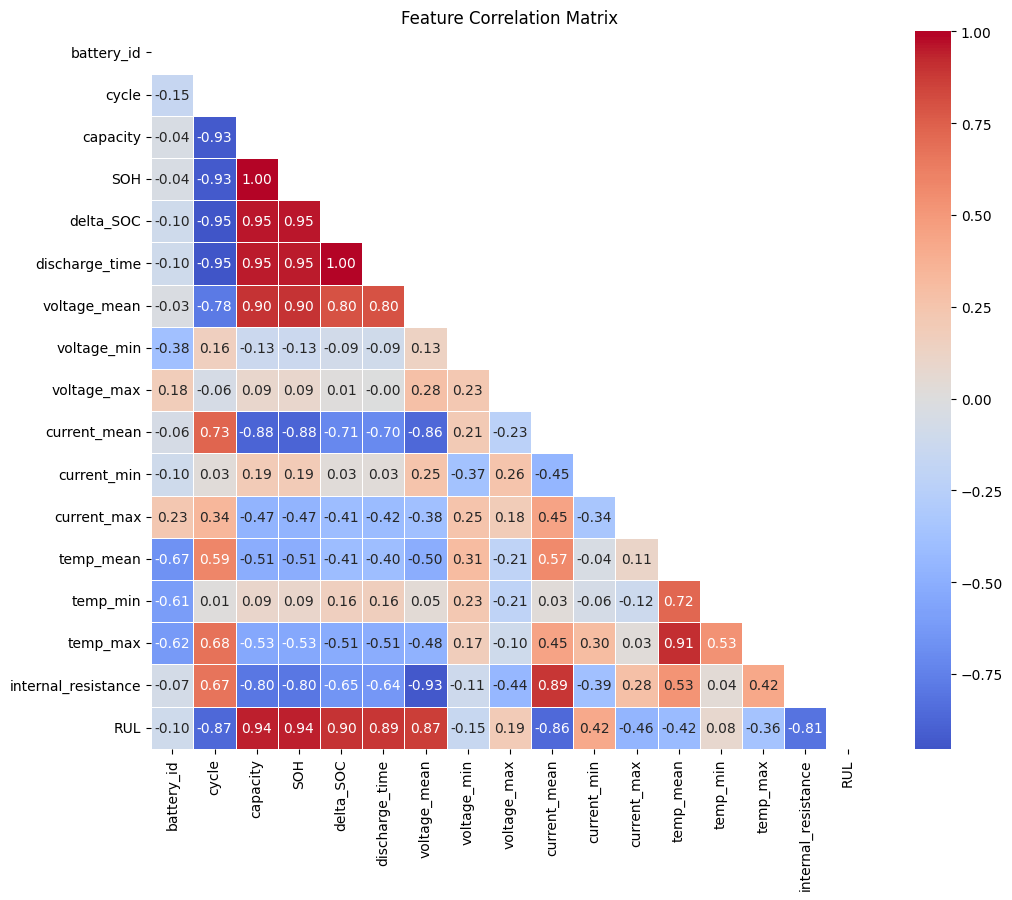

In [236]:
# Compute correlation matrix
correlation_matrix = features.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(11, 9))

# Create heatmap using seaborn
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center colormap at 0
            fmt='.2f',  # Format correlation values to 2 decimal places
            square=True,  # Make cells square
            linewidths=0.5)  # Add lines between cells

plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [237]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

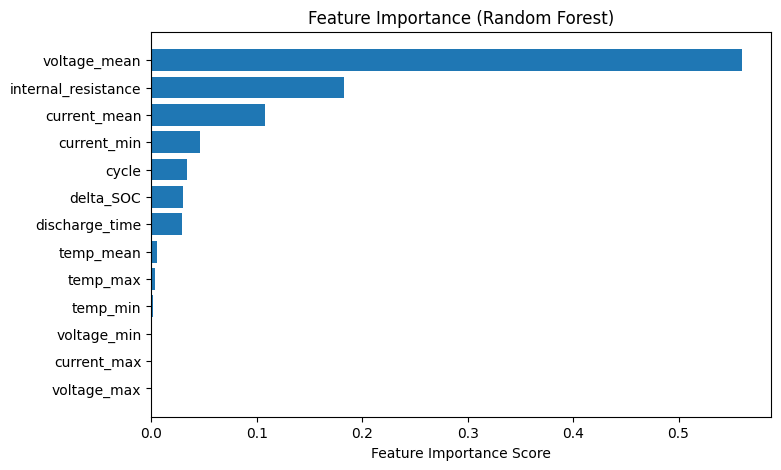

In [250]:
X = features.drop(columns=["battery_id","RUL", "SOH" , "capacity"])  # Drop the target variable and non-feature columns
y = features["RUL"]

model = RandomForestRegressor()
model.fit(X, y)

# Plot feature importance
importances = model.feature_importances_
all_features = X.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8, 5))
plt.barh(range(len(importances)), importances[sorted_idx], align="center")
plt.yticks(range(len(importances)), [all_features[i] for i in sorted_idx])
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance (Random Forest)")
plt.show()

## Normalize the features

In [ ]:
# from sklearn.preprocessing import StandardScaler, RobustScaler

# scaler = StandardScaler()

# cols_to_scale = features.columns.difference(['battery_id', 'cycle', 'capacity', 'SOH']) 

# features[cols_to_scale] = scaler.fit_transform(features[cols_to_scale])

In [241]:
features.head()

,battery_id,cycle,capacity,SOH,delta_SOC,discharge_time,voltage_mean,voltage_min,voltage_max,current_mean,current_min,current_max,temp_mean,temp_min,temp_max,internal_resistance,RUL
0,5,1,1.856487,0.928244,-0.975548,3690.234,3.529778,2.612467,4.186092,-1.818672,-2.015375,0.000729,32.572328,24.325993,38.982181,0.125172,124.0
1,5,2,1.846327,0.923164,-0.980300,3672.344,3.537287,2.587209,4.186092,-1.817552,-2.015375,0.001551,32.725235,24.685948,39.033398,0.122237,123.0
2,5,3,1.835349,0.917675,-0.985858,3651.641,3.543720,2.651917,4.186092,-1.816470,-2.015375,0.001484,32.642862,24.734266,38.818797,0.121487,122.0
3,5,4,1.835263,0.917631,-0.991309,3631.563,3.543645,2.592948,4.186092,-1.825584,-2.015375,0.001547,32.514876,24.652244,38.762305,0.120511,121.0
4,5,5,1.834646,0.917323,-0.991962,3629.172,3.542377,2.557492,4.186092,-1.826085,-2.015375,0.001551,32.382349,24.518700,38.665393,0.120239,120.0


## Select important features for training

In [251]:
# Select features for training
selected_features = ["delta_SOC", "cycle", "discharge_time", "voltage_mean", "current_mean", "current_min","temp_mean", "internal_resistance"]

inputs = features[selected_features]
target = features["RUL"]  

# Model training. We start with Random forest

### Split into train and test sets

Mean Absolute Error (MAE): 3.13 cycles
Mean Squared Error (MSE): 19.01
Root Mean Squared Error (RMSE): 4.36 cycles
R² Score: 0.9918


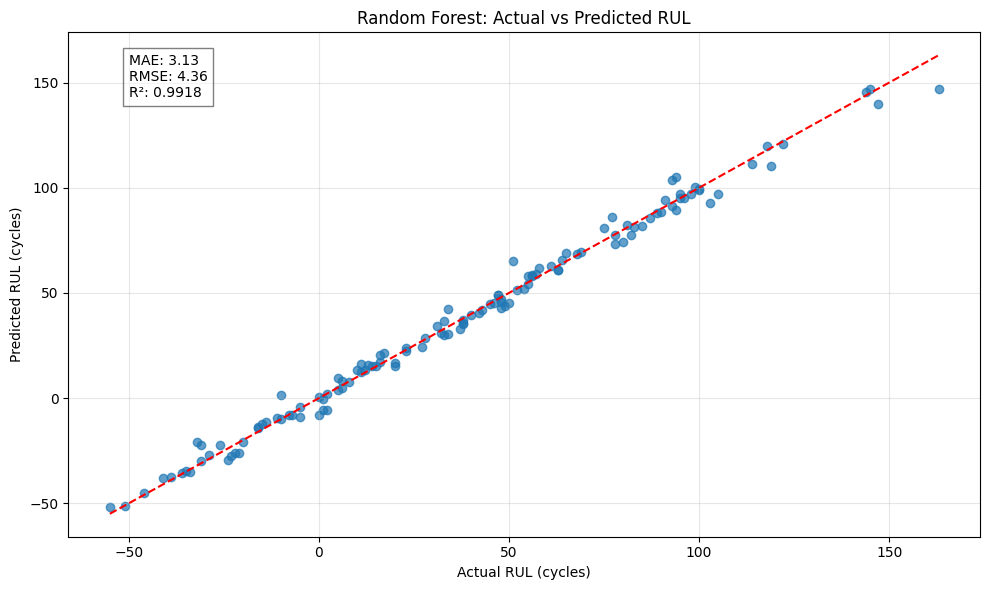

In [252]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=42)

# Initialize the model
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=10,         # Maximum depth of the trees
    min_samples_split=5,  # Minimum samples required to split an internal node
    min_samples_leaf=2,   # Minimum samples required to be at a leaf node
    max_features='sqrt'   # Number of features to consider when looking for the best split
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} cycles")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} cycles")
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual RUL (cycles)')
plt.ylabel('Predicted RUL (cycles)')
plt.title('Random Forest: Actual vs Predicted RUL')
plt.grid(True, alpha=0.3)

# Add text with metrics
plt.text(y_test.min() + 5, y_test.max() - 20, 
         f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}", 
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [181]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## Save the model

In [255]:
import joblib

joblib.dump(rf_model, "battery_rul_model.pkl")

['battery_rul_model.pkl']

## Load the model for inference

Mean Absolute Error (MAE): 1.84 cycles
Mean Squared Error (MSE): 8.05
Root Mean Squared Error (RMSE): 2.84 cycles
R² Score: 0.9971


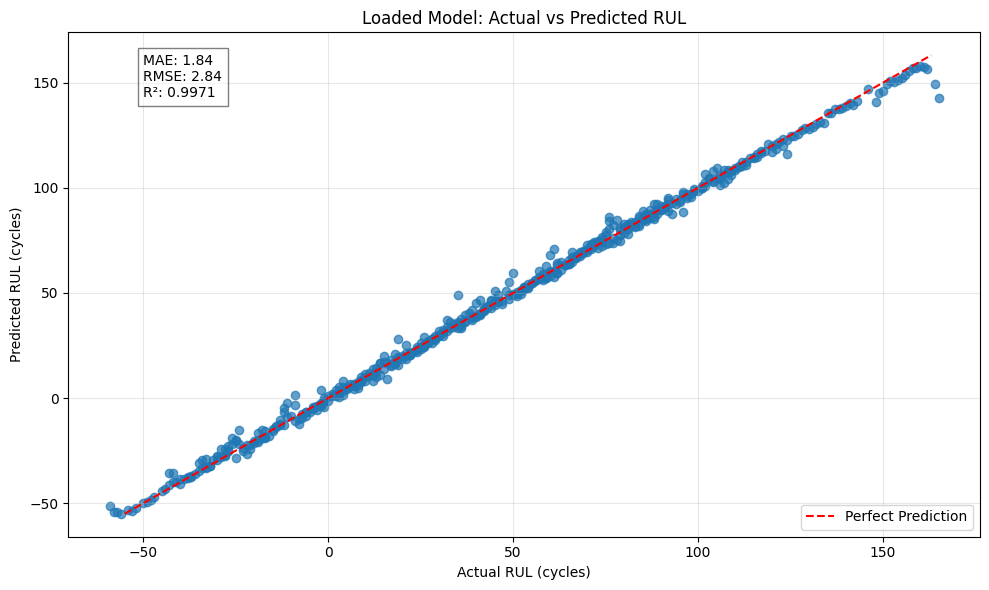

In [256]:
# Load the model
loaded_model = joblib.load("battery_rul_model.pkl")

# Make predictions with the loaded model
y_pred_loaded = loaded_model.predict(X_train)

# Calculate metrics
mae_loaded = mean_absolute_error(y_train, y_pred_loaded)
mse_loaded = mean_squared_error(y_train, y_pred_loaded)
rmse_loaded = np.sqrt(mse_loaded)
r2_loaded = r2_score(y_train, y_pred_loaded)

print(f"Mean Absolute Error (MAE): {mae_loaded:.2f} cycles")
print(f"Mean Squared Error (MSE): {mse_loaded:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_loaded:.2f} cycles")
print(f"R² Score: {r2_loaded:.4f}")

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_loaded, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual RUL (cycles)')
plt.ylabel('Predicted RUL (cycles)')
plt.title('Loaded Model: Actual vs Predicted RUL')
plt.grid(True, alpha=0.3)

# Add text with metrics
plt.text(y_test.min() + 5, y_test.max() - 20, 
         f"MAE: {mae_loaded:.2f}\nRMSE: {rmse_loaded:.2f}\nR²: {r2_loaded:.4f}", 
         bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.tight_layout()
plt.show()

### try a better regressor model

# XGBoost

In [246]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [253]:
# Define a more efficient parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 150, 200],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'min_child_weight': [1, 3]
}

# Initialize the XGBoost regressor with fixed random state and objective
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Set up GridSearchCV with more efficient parameters
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit grid search on the training data
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# Get the best model
xgb_model = grid_search.best_estimator_

# Make predictions on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Mean Absolute Error (MAE): {mae_xgb:.2f} cycles")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f} cycles")
print(f"R² Score: {r2_xgb:.4f}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Best RMSE: 4.538889057241196
Mean Absolute Error (MAE): 2.88 cycles
Root Mean Squared Error (RMSE): 3.78 cycles
R² Score: 0.9938


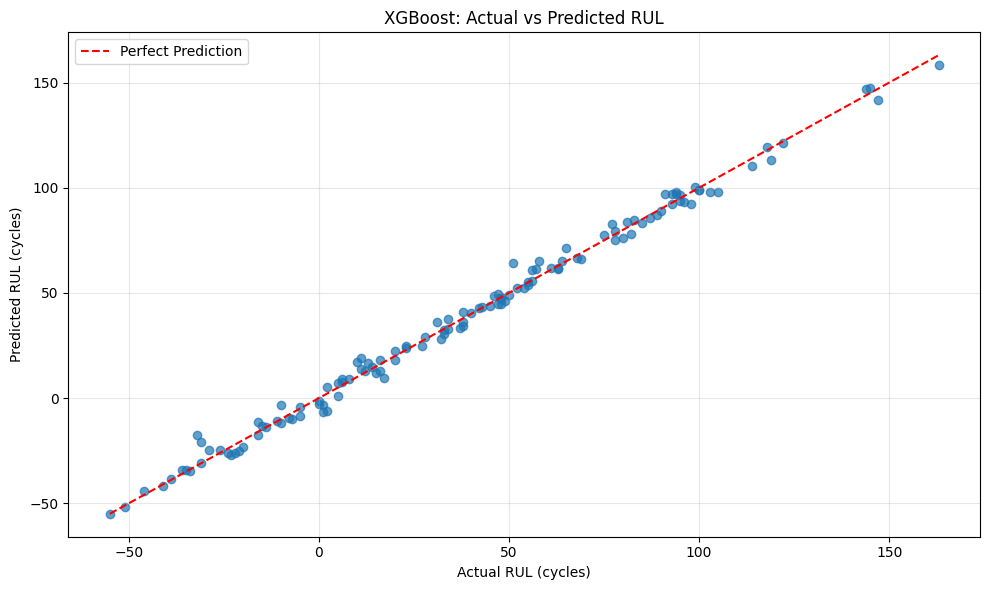

In [254]:

# Plot Actual vs Predicted RUL
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual RUL (cycles)")
plt.ylabel("Predicted RUL (cycles)")
plt.title("XGBoost: Actual vs Predicted RUL")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()